# Train


## Settings

In [ ]:
'''
this file is for constructing decision model using MobileNet.
the model gets a dog image as input and decide if the dog in the given image is “pooping”, “peeing” or “nothing”(nether pooping nor peeing).
'''

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras import backend as K
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from IPython.display import Image

%matplotlib inline

In [2]:
# for Google Drive mount
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
data_dir = '/content/gdrive/My Drive/train'
data_dir = pathlib.Path(data_dir)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')


In [4]:
# image data generator
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)


train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode='categorical')


validation_generator = image_generator.flow_from_directory(directory=str(data_dir), 
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           batch_size=BATCH_SIZE,
                                                           classes = list(CLASS_NAMES),
                                                           class_mode='categorical',
                                                           subset='validation') 



Found 13765 images belonging to 3 classes.
Found 2752 images belonging to 3 classes.


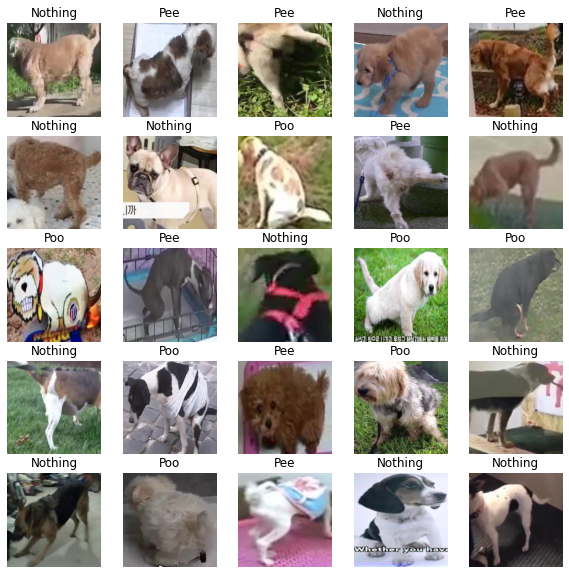

In [5]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)



## Model

In [6]:
mobile=keras.applications.mobilenet.MobileNet(weights='imagenet',include_top=False, input_shape=IMG_SHAPE)
mobile.trainable = True

global_average_layer = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(3, activation='softmax')

model = tf.keras.models.Sequential([
  mobile,
  global_average_layer,
  output_layer
])


model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

17227776/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


## Train

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./log/transer_learning_model', update_freq='batch')]
mc = ModelCheckpoint('best_mob_s3.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=50)

model.fit_generator(train_data_gen, 
             steps_per_epoch = train_data_gen.samples // BATCH_SIZE,
             epochs=100,
            #  batch_size = BATCH_SIZE,
             validation_data=validation_generator,
             validation_steps = 2,
             callbacks=[es, mc]

             )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
430/430 [==============================] - 6558s 15s/step - loss: 0.5424 - accuracy: 0.7973 - val_loss: 1.2000 - val_accuracy: 0.6562
Epoch 2/100
430/430 [==============================] - 65s 152ms/step - loss: 0.2610 - accuracy: 0.9069 - val_loss: 0.3406 - val_accuracy: 0.8750
Epoch 3/100
430/430 [==============================] - 65s 152ms/step - loss: 0.1813 - accuracy: 0.9358 - val_loss: 0.1722 - val_accuracy: 0.8906
Epoch 4/100
430/430 [==============================] - 65s 151ms/step - loss: 0.1568 - accuracy: 0.9433 - val_loss: 0.3816 - val_accuracy: 0.8906
Epoch 5/100
430/430 [==============================] - 65s 151ms/step - loss: 0.1235 - accuracy: 0.9569 - val_loss: 0.2678 - val_accuracy: 0.8906
Epoch 6/100
430/430 [==============================] - 65s 152ms/step - loss: 0.1061 - accuracy: 0.9648 - val_loss: 0.0424 - val_accuracy: 0.9844
Epoch 7/100
430/430 [===========================

## save the model

In [8]:
model.save('/content/gdrive/My Drive/models/mobilenet_small3')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/mobilenet_small3/assets


# Test

In [ ]:
# prediction part

predict_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

predict_dir = '/content/gdrive/My Drive/Test_2/'
predict_dir = pathlib.Path(predict_dir)

predict_data_gen = predict_generator.flow_from_directory(directory=str(predict_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode='categorical')

Found 0 images belonging to 3 classes.


In [ ]:
predict_batch, p_label_batch = next(predict_data_gen)
output = tl_model.predict_generator(predict_batch)

NameError: ignored